## Implementing an algorithm for finding the systole of a STS

In [23]:
import os
import numpy as np

from surface_dynamics.all import *
from matplotlib import pyplot as plt

import collections 
import time



### First, we need a way to act on STSs using a given matrix in $SL_2(\mathbb{Z})$.

### To that end, we first code an algorithm to decompose a given matrix into the standard generators $S = \begin{bmatrix} 0 & - 1\\ 1 & 0 \end{bmatrix}, L = \begin{bmatrix}1 & 1 \\ 0 & 1 \end{bmatrix}$

In [15]:



D = OrigamiDatabase()

def matrix_in_gens_temp(m): #expressing a matrix in terms of the rotation and the shear.
    s = matrix([[0,-1],[1,0]])
    l = matrix([[1,1],[0,1]])
    moves = []
    while abs(m[1][0])>0:
        if abs(m[0][0]) < abs(m[1][0]):
            m = s*m
            #print m
            moves.append(s)
        if Integer(m[1][0]) != 0:
            n,r = divmod(Integer(m[0][0]),Integer(m[1][0]))
            #print n
            #print r
            if r >=0:
                #print m
                m = l^(-n)*m
                moves.append(l^(-n))
            elif r < 0:
                n = -divmod(Integer(-m[0][0]),Integer(m[1][0]))[0]
                #print n
                r = -divmod(Integer(-m[0][0]),Integer(m[1][0]))[1]
                #print r
                m = l^(-n)*m
                moves.append(l^(-n))
    if m[0][0] < 0:
        moves.append(s)
        moves.append(s)
        m=s^2*m
        return moves, m
    else:
        return moves, m
    
def matrix_in_gens(g):
    mat, m = matrix_in_gens_temp(g)
    word = []
    for n in mat:
        word.append(n^(-1))
    word.append(m)
    return word

def sl2zmatrix_with_1stcol(vector):  # This code gets us an $SL_2(\mathbb{Z})$ matrix by completing an input first column.
    d, u, v = xgcd(vector[0],vector[1])
    M = matrix([[vector[0],-v],[vector[1], u]])
    return M





### Next, using a representation of the matrix in terms of the standard generators, we can act on a given STS in the by the following:

In [16]:
def ln_on_surf(shear_matrix, origami):
    n = shear_matrix[0][1]
    new_o = origami
    if n > 0:
        for i in range(abs(n)): 
            new_o = Origami(new_o.r(), new_o.r().inverse()*new_o.u())
    elif n < 0:
        for i in range(abs(n)):
            new_o = Origami(new_o.r(),new_o.r()*new_o.u())
    return (new_o, n)

def s2inv_on_surf(origami):
    return Origami(origami.u(), origami.r_inv())

def s_on_surf(origami):
    return Origami(origami.u_inv(), origami.r())

def matrix_on_surf(matrix, origami):
    mat_in_words = matrix_in_gens(matrix)
    trans_steps = []
    new_o = origami
    for mat in mat_in_words[::-1]:
        if mat[1][0] == 0:
            if mat[0][1] != 0:
                new_o = ln_on_surf(mat, new_o)[0]
                trans_steps.append(mat[0][1])
                
            elif mat[0][1] == 0:
                if mat[0][0] == -1:
                    for i in range(2):
                        new_o = s2inv_on_surf(new_o)
                        trans_steps.append('s_inv')
        else:
            new_o = s2inv_on_surf(new_o)
            trans_steps.append('s_inv')
    return (new_o, trans_steps)

### For example, given a square-tiled surface defined by permutations $\sigma = (1, 2)$ and $\tau = (1,3)$, and a matrix in $A = \begin{bmatrix} 19 & -5 \\ 23 & -6 \end{bmatrix}$, we can act on the surface using matrix_on_surf

In [17]:
A = sl2zmatrix_with_1stcol([19,23])

In [18]:
A

[19 -5]
[23 -6]

In [19]:
O = Origami('(1,2)','(1,3)')

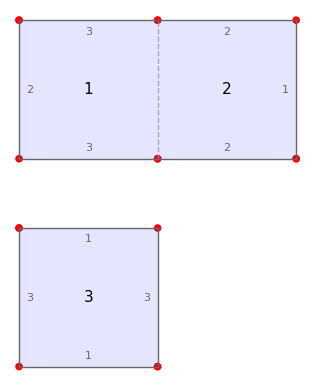

In [20]:
O.show()

In [21]:
P = matrix_on_surf(A, O)

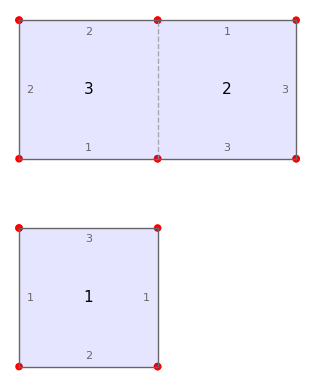

In [22]:
P[0].show()

### The following code now computes the length of systole of a given STS.

In [26]:
def naive_upper_bound_sys(O): 
    #Given an origami, look at the cycle decompositions of the two permutations. Return the length of the shortest cycle 
    return min(min(O.r().cycle_type()), min(O.u().cycle_type()))
    
def primitive_vectors_lessthaneq_L(L):
    vectors = [[0,1],[1,0],[-1,0]]
    for i in range(1, L+1):
        j = 1
        while (i^2+j^2) <= L^2 and gcd(i, j) == 1:
            vectors.append([i, j])
            vectors.append([-i, j])
            j += 1
    return vectors

def support(permutation):
    N = permutation.parent().degree()
    L = []
    for i in range(1, N+1):
        if permutation(i) != i:
            L.append(i)    
    return L   

def comm(O_M):
    return O_M.u_inv()*O_M.r_inv()*O_M.u()*O_M.r()
        
def assoc_vertex_from_sqlabel(list_of_cycles, i):
    for cyc in list_of_cycles:
        if i in support(cyc):
            return cyc
        

        

    
    
    
def gamma_v(O, v):
    M = sl2zmatrix_with_1stcol(v).inverse()
    O_M, trans_list = matrix_on_surf(M, O)
    c = comm(O_M)
    L = collections.deque(support(c))
    cycles = c.cycles() #these should be the vertices. 
    edges_weights = []
    
    while len(L) > 0:
        i = L[0]
        
        
        k = 1
        while (O_M.r()^k)(i) not in L:
          
            k += 1
        j = (O_M.r()^k)(i) 
    
        L.popleft()
        edges_weights.append([assoc_vertex(cycles, i), assoc_vertex(cycles, j), k*np.linalg.norm(v)])
        
   
    return Graph([cycles, edges_weights],multiedges=True, loops=True, weighted=True)


###########################################################
def associated_orig_singularity(orig_origami, transformed_origami, square_label, trans_steps):
    #cycles_orig = comm(orig_origami).cycles()
    cycles_trans = comm(transformed_origami).cycles()
    temp_sing = assoc_vertex_from_sqlabel(cycles_trans, square_label)
    #print temp_sing
    temp_origami = transformed_origami
    for step in trans_steps[::-1]:
        if step == 's_inv':
            
            temp_origami = s_on_surf(temp_origami)
            temp_r = temp_origami.r()
            temp_r_inv = temp_origami.r_inv()
            temp_sing = temp_r_inv*temp_sing*temp_r
            #print temp_sing
        else:
            temp_origami = ln_on_surf(matrix([[1,-step],[0,1]]), temp_origami)[0]
    return temp_sing
    
def associated_orig_singularity2(orig_origami, transformed_origami, square_label, trans_steps):
    #cycles_orig = comm(orig_origami).cycles()
    cycles_trans = comm(transformed_origami).cycles()
    temp_sing = assoc_vertex_from_sqlabel(cycles_trans, square_label)
    temp_origami = transformed_origami
    trans_steps.pop()
    for step in trans_steps:
        temp_origami = temp_origami.horizontal_twist(-step)
        temp_origami = s_inv_on_surf(temp_origami)
        temp_r = temp_origami.r()
        temp_r_inv = temp_origami.r_inv()
        temp_sing = temp_r_inv*temp_sing*temp_r
    return temp_sing
    
        


def Gamma_v(O, v):
    M = sl2zmatrix_with_1stcol(v).inverse()
    O_M, trans_steps = matrix_on_surf(M, O)
    c = comm(O_M)
    L = collections.deque(support(c))
    cycles_orig = comm(O).cycles() #these should be the vertices. 
    #cycles_trans = c.cycles()
    edges_weights = []
    
    while len(L) > 0:
        i = L[0]
        
        
        k = 1
        while (O_M.r()^k)(i) not in L:
          
            k += 1
           
        
        j = (O_M.r()^k)(i) 
        
        L.popleft()
        #edges_weights.append([assoc_vertex(cycles_trans, i), assoc_vertex(cycles_trans, j), k*np.linalg.norm(v)])
        edges_weights.append([associated_orig_singularity(O, O_M, i, trans_steps), associated_orig_singularity(O, O_M, j, trans_steps), k*np.linalg.norm(v)])
        
    
    
    return Graph([cycles_orig, edges_weights],multiedges=True, loops=True, weighted=True)



def Gamma(O):
    S = primitive_vectors_lessthaneq_L(naive_upper_bound_sys(O))
    edges = []
    for v in S:
        G_v = Gamma_v(O, v)
        edges += G_v.edges()
    vertices = G_v.vertices()
    return Graph([vertices, edges], multiedges=True, loops=True, weighted=True)
        
        
def systole_length(O):
    G = Gamma(O)
    graph_cycles = G.cycle_basis(output='edge')
    cycle_lengths = []
    for cyc in graph_cycles:
        length = 0
        for e in cyc:
            length += e[2]
        cycle_lengths.append(length)
    return min(cycle_lengths)    

### For instance

In [29]:
systole_length(O)

1.0

In [31]:
systole_length(P[0])

1.0

In [32]:
Q = Origami('(1,2)(3,4,5,6)','(1,5,6,3)(2,4)')

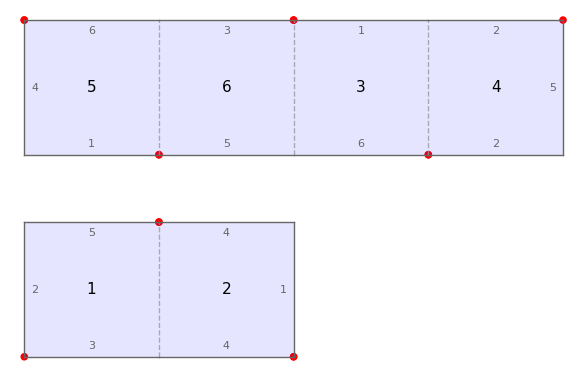

In [33]:
Q.show()

In [34]:
systole_length(Q)

1.4142135623730951